# Exploratory Data Analysis for RSI Divergence applied to FOREX Instruments

In [83]:
import pandas as pd
import numpy as np
import mplfinance as mpl
import talib as ta
from tqtklib.file_manager.file_manager import FileManager, StorageType
from scipy.signal import argrelextrema, find_peaks

# Constants

In [84]:
COLUMNS = ["time", "open", "high", "low", "close", "volume"]

# Open Data

In [85]:
file_man = file_manager = FileManager(StorageType.FILE_SYSTEM)
df = file_man.open("../../data/EURUSD_5 Mins_Bid_2024.03.16_2025.03.16.csv", parse_dates=True, header=0, names=COLUMNS, index_col="time")
df.head()

,open,high,low,close,volume
time,,,,,
2024-03-17 18:00:00,1.08905,1.08905,1.08882,1.08882,28.80
2024-03-17 18:05:00,1.08887,1.08904,1.08887,1.08898,64.44
2024-03-17 18:10:00,1.08897,1.08903,1.08866,1.08881,101.13
2024-03-17 18:15:00,1.08881,1.08886,1.08819,1.08876,70.49
2024-03-17 18:20:00,1.08876,1.08898,1.08848,1.08897,81.40


# Calculate Features

In [86]:
df["RSI-14"] = ta.RSI(df["close"], timeperiod=14)
df["SMA"] = ta.SMA(df["close"], timeperiod=20)
df["RSI-14-inv"] = 50 - df["RSI-14"]  # mirroring the RSI around 50 level to find troughs
# df.dropna(inplace=True)
df.tail()

,open,high,low,close,volume,RSI-14,SMA,RSI-14-inv
time,,,,,,,,
2025-03-14 17:35:00,1.08837,1.08854,1.08837,1.08853,102.90,63.047238,1.088215,-13.047238
2025-03-14 17:40:00,1.08853,1.08855,1.08829,1.08839,340.92,56.798219,1.088231,-6.798219
2025-03-14 17:45:00,1.08839,1.08844,1.08825,1.08839,251.46,56.798219,1.088253,-6.798219
2025-03-14 17:50:00,1.08838,1.08840,1.08810,1.08816,382.23,47.775802,1.088257,2.224198
2025-03-14 17:55:00,1.08817,1.08817,1.08742,1.08765,790.21,34.637006,1.088240,15.362994


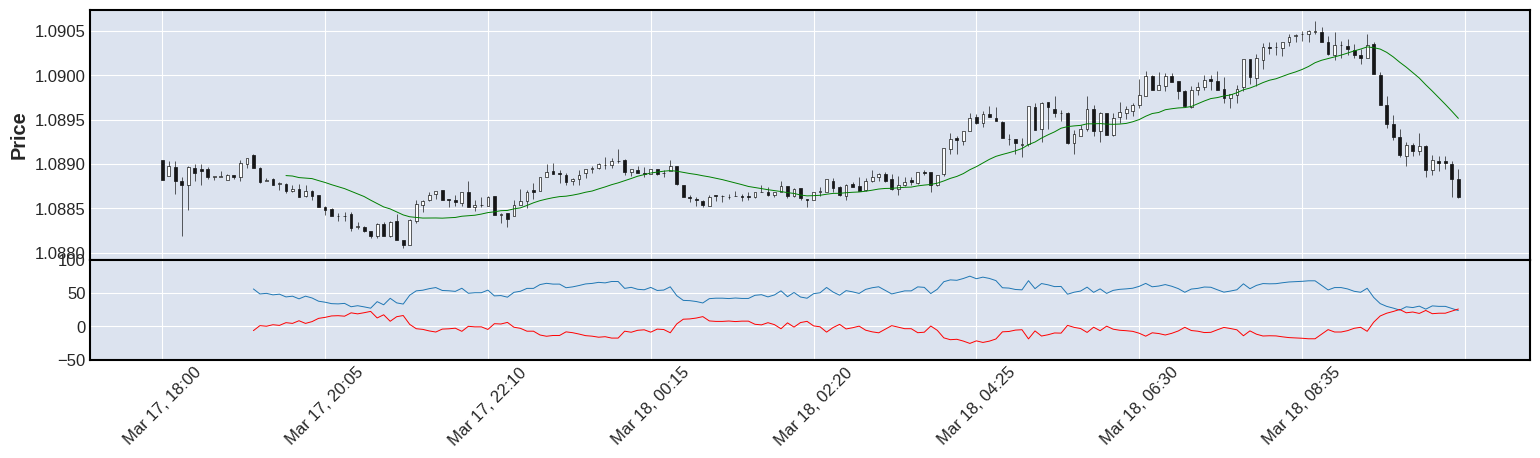

In [103]:
ao = [
    mpl.make_addplot(df["RSI-14"][0:200],type='line',width=0.7, panel=1 ,alpha=1, secondary_y=False, ylim=(-50,100)),
    mpl.make_addplot(df["RSI-14-inv"][0:200],type='line',width=0.7, panel=1 ,alpha=1, secondary_y=False, color="red", ylim=(-50,100)),
    mpl.make_addplot(df["SMA"][0:200],type='line',width=0.7, panel=0 ,alpha=1, secondary_y=False, color="green")
]

mpl.plot(df[0:200], figsize=(20,5), type="candle", addplot=ao)

In [97]:
def calculate_extremes(df, window=14, order=5, component="close"):
    
    # Find local peaks and troughs in the price series
    price_peaks = find_peaks(df[component])
    
    return price_peaks

In [98]:
peaks = calculate_extremes(df, component="RSI-14", order=5)
troughs = calculate_extremes(df, component="RSI-14-inv", order=5)
df["price-tops"] = np.nan
for maximum in peaks[0]:
    df.loc[df.iloc[maximum].name, "rsi-tops"] = df.loc[df.iloc[maximum].name]["RSI-14"]


for minimum in troughs[0]:
    df.loc[df.iloc[minimum].name, "rsi-troughs"] = df.loc[df.iloc[minimum].name]["RSI-14"]
    
    

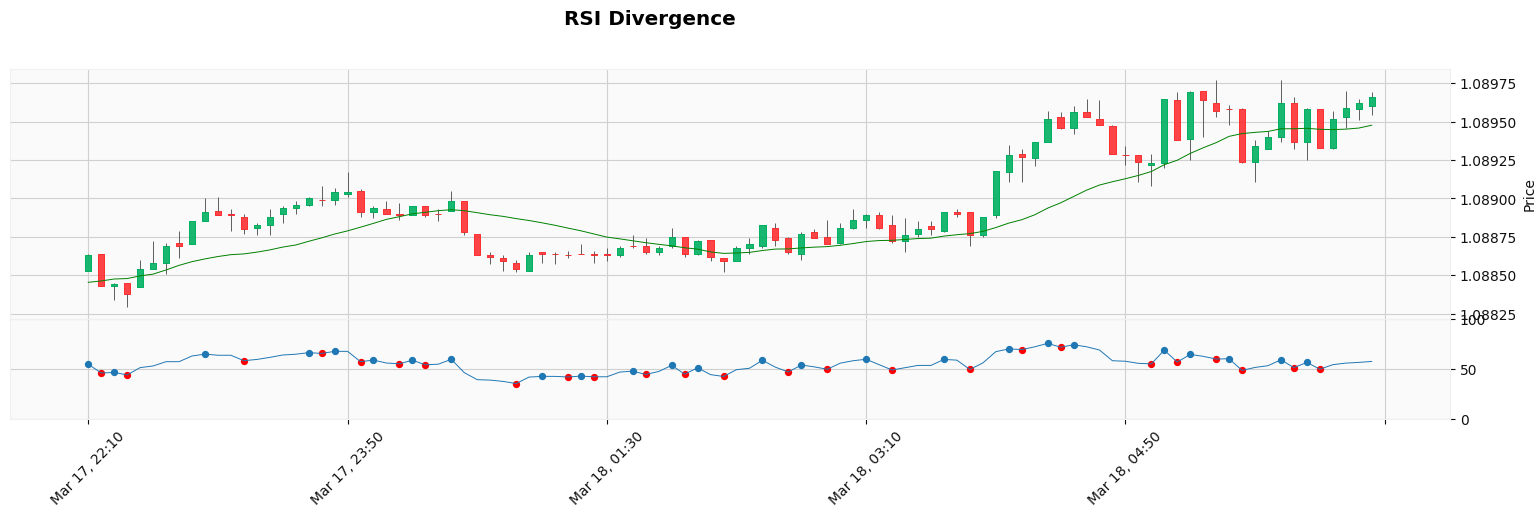

In [99]:
ao = [
    mpl.make_addplot(df["RSI-14"][50:150],type='line',width=0.7, panel=1 ,alpha=1,ylim=(0,100)),
    mpl.make_addplot(df["rsi-tops"][50:150],scatter=True,width=0.7, panel=1 ,alpha=1),
    mpl.make_addplot(df["rsi-troughs"][50:150],scatter=True,width=0.7, panel=1 ,alpha=1, color="red"),
    mpl.make_addplot(df["SMA"][50:150],type='line',width=0.7, panel=0 ,alpha=1, secondary_y=False, color="green")
]

mpl.plot(df[50:150], figsize=(20,5), type="candle", addplot=ao, volume=False, title="RSI Divergence", style="yahoo", show_nontrading=False)

## Calculate Signals

Short Signal

$(close_t > close_{t-1}) \land (rsi_i < rsi_{t-1})$ 

Where

- $t$: Time of last RSI peak
- $t-1$: Time of previous peak

Signal is placed at closing of the bar after the signal: at $t+1$

In [92]:
# short signal

df_signal_short = df[~df["rsi-tops"].isna()].copy(deep=True)  # remove all rows without rsi-tops
df_signal_short["close_i"] = df_signal_short["close"]  # bring the current close price
df_signal_short["close_i-1"] = df_signal_short["close"].shift(1)  # bring the previous RSI top close price
df_signal_short["rsi-top_i-1"] = df_signal_short["rsi-tops"].shift(1)  # bring the previous RSI top value
df_signal_short.dropna(subset=["rsi-top_i-1"], inplace=True)  # remove all rows without rsi-tops_i-1

NEW_COLUMNS = ["close_i", "close_i-1", "rsi-top_i-1","short-condition"]

# calculate the short signal
mask = (df_signal_short["close_i"] > df_signal_short["close_i-1"]) & (df_signal_short["rsi-tops"] < df_signal_short["rsi-top_i-1"])
df_signal_short.loc[mask, "short-condition"] = 1

df = pd.merge(df, df_signal_short[NEW_COLUMNS], how="left", left_index=True, right_index=True)

In [93]:
df["short-signal"] = df["short-condition"].shift(1)  # shift the signal to the next bar

In [94]:
df[["close", "close_i-1", "rsi-tops", "rsi-top_i-1", "short-signal"]]

,close,close_i-1,rsi-tops,rsi-top_i-1,short-signal
time,,,,,
2024-03-17 18:00:00,1.08882,NaN,NaN,NaN,NaN
2024-03-17 18:05:00,1.08898,NaN,NaN,NaN,NaN
2024-03-17 18:10:00,1.08881,NaN,NaN,NaN,NaN
2024-03-17 18:15:00,1.08876,NaN,NaN,NaN,NaN
2024-03-17 18:20:00,1.08897,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-03-14 17:35:00,1.08853,1.08836,63.047238,57.959848,NaN
2025-03-14 17:40:00,1.08839,NaN,NaN,NaN,NaN
2025-03-14 17:45:00,1.08839,1.08853,56.798219,63.047238,NaN


In [95]:
mask = df["short-signal"] == 1
df.loc[df[mask].index, "signal_price"] = df[mask]["high"] + 0.0001

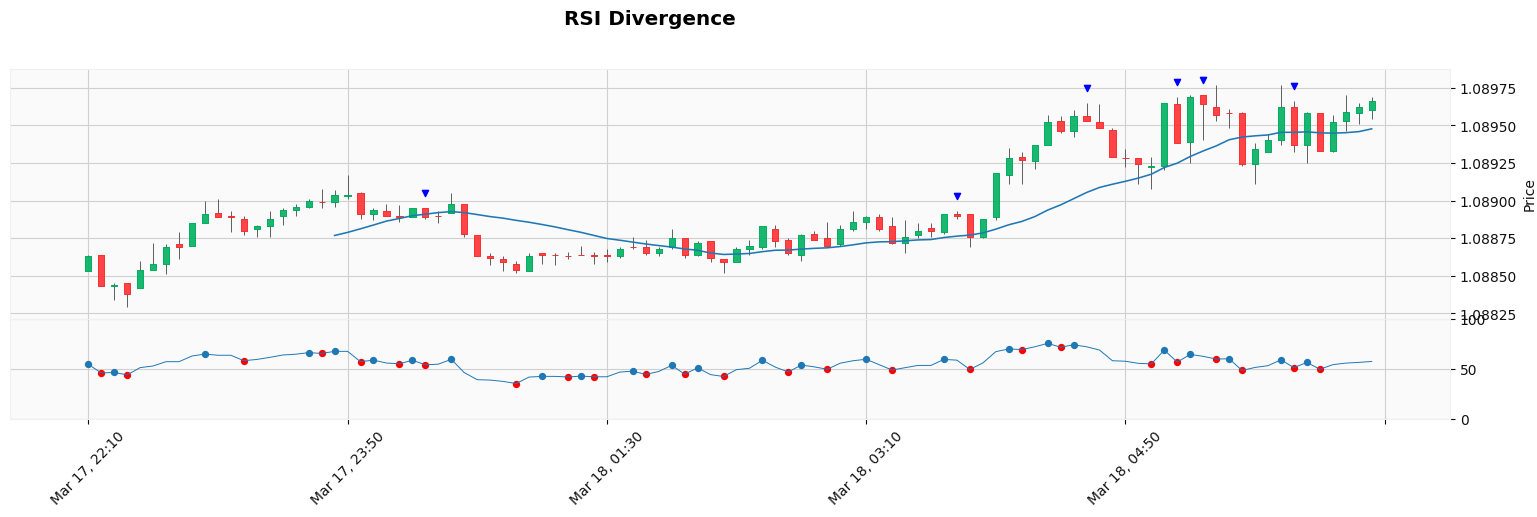

In [96]:
ao = [
    mpl.make_addplot(df["RSI-14"][50:150],type='line',width=0.7, panel=1 ,alpha=1,ylim=(0,100)),
    mpl.make_addplot(df["rsi-tops"][50:150],scatter=True,width=0.7, panel=1 ,alpha=1),
    mpl.make_addplot(df["rsi-troughs"][50:150],scatter=True,width=0.7, panel=1 ,alpha=1, color="red"),
    mpl.make_addplot(df["signal_price"][50:150],scatter=True,width=0.7, panel=0 ,alpha=1, color="blue", marker="v", markersize=20),
]

mpl.plot(df[50:150], figsize=(20,5), type="candle", addplot=ao, volume=False, title="RSI Divergence", mav=20, style="yahoo", show_nontrading=False)